# Process CF Parcel-level Annotations

1. Batch 1: 5,500 residential parcels from a simple random sample (3.5%) across each of the 51 income strata
2. Batch 2: ~3,000 residential parcels matching to AANC permits
3. Batch 3: ~16,000 residential parcels (latest estimate) according Neyman allocation per the power analysis to detect a significant effect in the permitted new small building proportion in low vs. high income neighborhoods

**Outline:**

Part 1: 
- Extract CF polygons -> This gives us a map of small buildings in each year (gdf)
- Identify newly constructed small buildings (entirely new, replacement of old building)

*Part 1 outputs:*
- parcel_density: DataFrame of number of small buildings per parcel in 2016 and 2020
- CF_area_coverage: shp of the parcels annotated by CF
- sbuild_2020_compared: geoDataFrame of 2020 small buildings, including a flag for whether they are new constructions

Part 2: 
- Permit-matching for newly constructed small buildings
- Outcome analysis 

In [1]:
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
import pyproj
import seaborn as sns
from tqdm import tqdm
from shapely import wkt
import shapely

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Load functions 
%run ADU_permit_matching-polygon-pipeline.ipynb import compare_building_footprint

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
CF_FP = os.path.join(OAK_FP, 'CloudFactory')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

# Parameters
batch = 1
completion = 88 # (completion rate of the batch so we can update as CF progresses without overwriting)
construction_detection = ['AT', 'CF', 'hybrid'][0]
min_sqft = [0, 11.1484][1] # Note that 120sqft = 11.1484 sqm

In [4]:
# Input data
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

In [5]:
# Functions
def compare_smallbuildings(gdf, comp_list, name_list, model_params):
    """
    Compares the area of each building in gdf to the buildings in the GeoDataFrames in
    comp_list to check for expansions/constructions.
    """
    match_cols = ['building_index', 'APN', 'geometry'] +  [
        'expansion_{}_flag'.format(comp_name) for comp_name in name_list] + [
        'diff_{}_value'.format(comp_name) for comp_name in name_list]
    
    if gdf is None:
        return None
    
    for comp_name in name_list:
        gdf['expansion_{}_flag'.format(comp_name)] = None
        gdf['diff_{}_value'.format(comp_name)] = None
    
    for comp, comp_name in zip(comp_list, name_list):
        
        if comp is None:
            continue
        
        # Check expansion
        if len(gdf) > 0:
            comp['geometry_comp'] = comp['geometry']

            # Get polygon in comp gdf to which we compare each polygon
            comp = comp.reset_index()
            gdf = gdf.sjoin(comp[['geometry', 'geometry_comp']], how='left', predicate='intersects')
            gdf['iou_comp'] = gdf.apply(lambda row: (
                row['geometry'].intersection(comp.iloc[int(row['index_right'])]['geometry'])).area / 
                                    row['geometry'].area if pd.notnull(row['index_right']) else None, axis=1)

            # Have to account for potentially various matches for one inference (we compare to 
            # the one with highest overlap)
            gdf = gdf.sort_values('iou_comp', ascending=False)
            gdf.drop_duplicates(subset=['geometry'], keep='first', inplace=True)

            # Check expansion for each polygon
            gdf[['expansion_{}_flag'.format(comp_name), 'diff_{}_value'.format(comp_name)]] = gdf.apply(
                lambda row: compare_building_footprint(
                    base_geom=comp.iloc[int(row['index_right'])]['geometry'], 
                    new_geom=row['geometry'].union(comp.iloc[int(row['index_right'])]['geometry']), 
                    diff_type='protruding_poly', 
                    model_params=model_params, 
                    main_building_flag=False
                ) if pd.notnull(row['index_right']) else (True, True), 
                axis=1, result_type="expand")
            
            # Set area equal to the full polygon where we have a fully new small building
            gdf.loc[gdf['diff_{}_value'.format(comp_name)] == True, 'diff_{}_value'.format(comp_name)] = gdf.loc[
                gdf['diff_{}_value'.format(comp_name)] == True].to_crs('EPSG:26910')['geometry'].area

        gdf = gdf[match_cols]

    return gdf

## 1. Check batch completion and extract CF polygons

In [6]:
# Load batch data and batch query
# * Submitted parcels
submitted_parcels = glob.glob(os.path.join(CF_FP, 'images', 'batch{}'.format(batch), 'images', '*.png'))
# submitted_parcels = [p.split(os.path.sep)[-1].replace('.png', '') for p in submitted_parcels]

In [7]:
# Load extracted polygons
sbuild = pd.read_csv(
    os.path.join(OAK_FP, 'CloudFactory/results/Batch{}_{}/batch1_rough.csv'.format(batch, completion)), 
    dtype={'apn': str})
sbuild.rename(columns={'apn': 'APN'}, inplace=True)
sbuild.reset_index(inplace=True, drop=False)
sbuild.rename(columns={'index': 'building_index'}, inplace=True)
assert len(sbuild['building_index'].unique()) == len(sbuild)

In [8]:
# Impose minimum size for small buildings

# * Compute 2016 and 2020 areas
wgs84 = pyproj.CRS('EPSG:26910')
utm = pyproj.CRS('EPSG:4326')
project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform

sbuild['2016_min_area'] = sbuild['2016'].progress_apply(
    lambda geom: 0 if pd.isnull(geom) else shapely.ops.transform(project, wkt.loads(geom)).area)
sbuild['2020_min_area'] = sbuild['2020'].progress_apply(
    lambda geom: 0 if pd.isnull(geom) else shapely.ops.transform(project, wkt.loads(geom)).area)

n_builds = len(sbuild)
sbuild = sbuild.loc[(sbuild['2016_min_area'] >= min_sqft) | (sbuild['2020_min_area'] >= min_sqft)]

print('[INFO] Dropping {} small buildings that do not meet the minimum area threshold.'.format(
    n_builds - len(sbuild)))
sbuild = sbuild[['building_index', 'APN', '2016', '2020', 'exact_match', 'correct_procedure']]

100%|██████████| 912/912 [00:00<00:00, 11647.97it/s]

[INFO] Dropping 41 small buildings that do not meet the minimum area threshold.


In [9]:
# Make gdf for each year
sbuild16 = sbuild[['building_index', 'APN', '2016']].copy()
sbuild16 = sbuild16.loc[~sbuild16['2016'].isna()]
sbuild16['2016'] = sbuild16['2016'].apply(wkt.loads)
sbuild16 = gpd.GeoDataFrame(sbuild16, geometry='2016', crs='EPSG:4326')

sbuild20 = sbuild[['building_index', 'APN', '2020', 'exact_match', 'correct_procedure']].copy()
sbuild20 = sbuild20.loc[~sbuild20['2020'].isna()]
sbuild20['2020'] = sbuild20['2020'].apply(wkt.loads)
sbuild20 = gpd.GeoDataFrame(sbuild20, geometry='2020', crs='EPSG:4326')

In [10]:
# * Annotated parcels
annotated_parcels_files = glob.glob(
    os.path.join(CF_FP, 'exports', 'Batch{}_{}'.format(batch, completion), '*.json'))
annotated_parcels = [p.split(os.path.sep)[-1].replace('.json', '') for p in annotated_parcels_files]

smallbuild_parcels = sbuild['APN'].unique()

# Generate shp of annotated area
annotated_parcels_shp = sj_parcels_cbgs.loc[sj_parcels_cbgs['APN'].isin(annotated_parcels)].copy()

In [11]:
print('[INFO] Annotated {} parcels out of {} submitted parcels for batch {} at {}% completion'.format(
    len(annotated_parcels), len(submitted_parcels), batch, completion))
print('[INFO] {} parcels including small buildings across both years'.format(len(smallbuild_parcels)))

[INFO] Annotated 4904 parcels out of 5541 submitted parcels for batch 1 at 88% completion
[INFO] 825 parcels including small buildings across both years


### 1.1 Generate dataframe of small building counts per parcel and CF area coverage

In [12]:
if not os.path.exists(os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion))):
    os.makedirs(os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion)))

In [13]:
parcel_density = sbuild.notna().groupby(sbuild['APN'])[['2016', '2020']].sum().reset_index()

parcel_density = pd.DataFrame({'APN': annotated_parcels}).merge(
    parcel_density, how='left', validate='one_to_one')

parcel_density.fillna(0, inplace=True)
parcel_density.to_csv(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 
                 'parcel_density-min{}.csv'.format(int(min_sqft))), 
    index=False)

In [14]:
CF_area_coverage = sj_parcels_cbgs.loc[sj_parcels_cbgs['APN'].isin(annotated_parcels)]
CF_area_coverage.to_file(
    os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 'CF_area_coverage'))

In [15]:
print('[INFO] {} small buildings found in 2016; {} small buildings found in 2020'.format(
    int(parcel_density['2016'].sum()), int(parcel_density['2020'].sum())
))

[INFO] 811 small buildings found in 2016; 858 small buildings found in 2020


## 2. Identify newly constructed small buildings

Two ways to identify construction events: 1) Using CF annotations directly (i.e., whether a polygon was copy-pasted or not) `CF`; 2) using area-thresholds (this does not allow us to detect material changes to buildings that did not have a significant change on the building footprint) `AT`; 3) the hybrid method uses CF annotations directly for annotations made after the CF guideliness were issued, and uses the area threshold method for those made before the guidelines were issued.

In [16]:
# Cloud Factory detection
sbuild_2020_compared = sbuild20.copy()

sbuild_2020_compared['area'] = sbuild_2020_compared.to_crs('EPSG:26910').geometry.area
sbuild_2020_compared['year'] = '2020'

#sbuild_2020_compared = pd.merge(
#    sbuild_2020_compared, sbuild16[['building_index', '2016']], on='building_index', validate='one_to_one')

# Construction event if exact_match == 0
sbuild_2020_compared['expansion_2016_flag_CF'] = 1 - sbuild_2020_compared['exact_match']

In [17]:
# Area Threshold detection
sbuild_2020_compared_AT = gpd.GeoDataFrame()

for parcel_apn in tqdm(sbuild20['APN'].unique()):
    # Get annual small building gdfs
    parcel_sbuild_2020 = sbuild20.loc[sbuild20['APN'] == parcel_apn].copy()
    parcel_sbuild_2016 = sbuild16.loc[sbuild16['APN'] == parcel_apn].copy()

    parcel_sbuild_2020.rename(columns={'2020': 'geometry'}, inplace=True)
    parcel_sbuild_2016.rename(columns={'2016': 'geometry'}, inplace=True)

    parcel_sbuild_2020 = gpd.GeoDataFrame(parcel_sbuild_2020, crs='EPSG:4326')
    parcel_sbuild_2016 = gpd.GeoDataFrame(parcel_sbuild_2016, crs='EPSG:4326')

    # Check for new constructions
    parcel_sbuild_2020 = compare_smallbuildings(
        gdf=parcel_sbuild_2020, comp_list=[parcel_sbuild_2016], 
        name_list=['2016'], 
        model_params={'area_threshold_main': None, 'area_threshold_small': 20, 
                      'negative_buffer': 0.5})

    # Append
    sbuild_2020_compared_AT = pd.concat([sbuild_2020_compared_AT, parcel_sbuild_2020])

if 'index_right' in sbuild_2020_compared.columns:
    sbuild_2020_compared_AT.drop('index_right', inplace=True, axis=1)
    
sbuild_2020_compared_AT.rename(columns={'expansion_2016_flag': 'expansion_2016_flag_AT'}, inplace=True)

100%|██████████| 815/815 [00:59<00:00, 13.81it/s]


In [18]:
# Merge
sbuild_2020_compared = pd.merge(
    sbuild_2020_compared, sbuild_2020_compared_AT[['building_index', 'expansion_2016_flag_AT']], 
    on='building_index', validate='one_to_one'
)

In [19]:
if construction_detection == 'CF':
    sbuild_2020_compared['expansion_2016_flag'] = sbuild_2020_compared['expansion_2016_flag_CF']
elif construction_detection == 'AT':
    sbuild_2020_compared['expansion_2016_flag'] = sbuild_2020_compared['expansion_2016_flag_AT']
elif construction_detection == 'hybrid':
    sbuild_2020_compared['expansion_2016_flag'] = sbuild_2020_compared.apply(
        lambda row: row['expansion_2016_flag_CF'] if row['correct_procedure'] == 1 else row['expansion_2016_flag_AT'], axis=1)
else:
    raise Exception('[ERROR] Check method for construction events.')
    
sbuild_2020_compared['expansion_2016_flag'] = sbuild_2020_compared['expansion_2016_flag'].astype(bool)

In [20]:
print('[INFO] We have {} small building annotations across {} parcels for both years.'.format(
    sbuild[['2016', '2020']].notna().sum().sum(), len(smallbuild_parcels)))
print('[INFO] We have {} small building annotations for 2020; and '
      'identify {} of these to be built after 2016'.format(
      len(sbuild_2020_compared), sbuild_2020_compared['expansion_2016_flag'].sum()))

[INFO] We have 1669 small building annotations across 825 parcels for both years.
[INFO] We have 858 small building annotations for 2020; and identify 72 of these to be built after 2016


In [21]:
sbuild_2020_compared[['APN', 'area', 'year', 'expansion_2016_flag']].to_csv(os.path.join(
    OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 
    'sbuild_2020_compared-{}-min{}.csv'.format(construction_detection, int(min_sqft))), index=False)

In [22]:
sbuild_2020_compared.to_file(os.path.join(
    OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(batch, completion), 
    'sbuild_2020_compared-{}-min{}'.format(construction_detection, int(min_sqft))), index=False)

### 2.1 Check whether we pass test cases
These are manually collected ground truth cases on parcels with no small building construction events (false), cases with entirely new small buildings (true-new) and cases with small buildings that replace old structures (true-replace).

In [23]:
# Batch 1
test_cases = {
    'true(new)': [
        '45120021', '44732030', '43933037', '44626011', '46432056', '43428123', 
        '27453041', '26462005', '30341002', '30334023', '47701055', '48125057',
        '29928063', '37317034', '27726026', '30330004', '30327016', '24960051', 
        '24529043', '46227003', '26123040', '41934030', '44228010', '49704006', 
        '49724012', '49902047', '49927002', '59949012', '65219015', '01511081', 
        '48611010', '48612015', '48635017', '48804008', '48804026', '49109059',
        '49119021', '49407021', '49709005', '49902084', '49916019', '56911050', 
        '56938060', '58629019', '59205028', '64920009', '65424001', '65937019', 
        '67032055', '67622042', '67849070', '68433070', '69205043', '69210133', 
        '69226014'
    ],
    'true(replace)': [
        '43406087', '42933015', '27409002', '26435035', '24509006', '26117066', 
        '24902060', '48144016', '42914030', '48419045', '49461011', '59214041',
        '67646033', '67832020', '47736020', '48446044', '49141060', '68918083'
    ],
    'false': [
        '44708058', '44629050', '43917076', '43409088', '42929009', '44626008', 
        '41944094', '42926032', '43915071', '42903018', '46714029', '44706008',
        '43920020', '42940022', '44627033', '46705041', '46707017', '43946024', 
        '43429050', '42108046', '42923006', '43903050', '42117003', '42950063',
        '43422021', '41917050', '42916008', '43424064', '42950046', '44638005', 
        '44709053', '45515080', '44232048', '42947023', '43925046', '43910021', 
        '46237003', '42908005', '44627041', '42906013', '43914059', '42924011', 
        '42114072', '27445085', '40304054', '24953062', '24927036', '24958007',
        '25404032', '27423086', '27437020', '27438048', '28213044', '28214011',
        '43412093', '43909051', '44245040', '46738010', '46740005', '01506001', 
        '47228068', '47229033', '47229085', '48426033', '48816030', 
        '56922048', # this is a hard case but it seems the small builds were just moved around
        '58923068', '59108040', '64906009', '65438025', '68945071', '42935022', 
        '43917140', '46207052', '65215028', '69525051'
    ], 
    'unsure': [
        '46705073', '48605010' # roof cover
    ]
}

In [24]:
new_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['true(new)'])].copy()
new_add = new_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
new_add['expansion'] = new_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

print('[INFO] True (new) additions: {}/{} out of {} cases'.format(
    new_add['expansion'].sum(), len(new_add), len(test_cases['true(new)'])))

replace_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['true(replace)'])].copy()
replace_add = replace_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
replace_add['expansion'] = replace_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

print('[INFO] True (replace) additions: {}/{} out of {} cases'.format(
    replace_add['expansion'].sum(), len(replace_add), len(test_cases['true(replace)'])))

false_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['false'])].copy()
false_add = false_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
false_add['expansion'] = false_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

print('[INFO] False additions: {}/{} out of {} cases'.format(
    len(false_add) - false_add['expansion'].sum(), len(false_add), len(test_cases['false'])))

[INFO] True (new) additions: 48/49 out of 55 cases
[INFO] True (replace) additions: 13/18 out of 18 cases
[INFO] False additions: 62/70 out of 76 cases


In [159]:
# Check all construction cases
ground_truth_cases = test_cases['true(new)'] + test_cases['true(replace)'] + test_cases['false']
sbuild_2020_compared = sbuild_2020_compared[['APN', 'area', 'year', 'expansion_2016_flag']]
sbuild_2020_compared.loc[
    (sbuild_2020_compared['expansion_2016_flag'] == True) & ~(sbuild_2020_compared['APN'].isin(ground_truth_cases))]

,APN,area,year,expansion_2016_flag
537,46705073,19.215,2020,True
657,48605010,19.980,2020,True
877,68432012,15.840,2020,True


In [ ]:
# Manual corrections?

### 2.2 Test specific cases

In [34]:
parcel_apn = '27409002'
parcel_sbuild = sbuild.loc[sbuild['APN'] == parcel_apn].copy()
parcel_sbuild_2020 = parcel_sbuild.loc[parcel_sbuild['year'] == '2020'].copy()
parcel_sbuild_2016 = parcel_sbuild.loc[parcel_sbuild['year'] == '2016'].copy()

# Check for new constructions
parcel_sbuild_2020 = compare_smallbuildings(
    gdf=parcel_sbuild_2020, comp_list=[parcel_sbuild_2016], 
    name_list=['2016'], 
    model_params={'area_threshold_main': None, 'area_threshold_small': 20, 
                  'negative_buffer': 0.5})

In [35]:
parcel_sbuild_2020

,APN,area,year,geometry,expansion_2016_flag,diff_2016_value
865,27409002,37.485,2020,"POLYGON ((-121.92719 37.33260, -121.92723 37.3...",False,0.0


## Test functions

In [6]:
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')
BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

In [7]:
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_res = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Permits
sj_parcel_permit = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(PERMIT_INPUT_FP, '..', 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])

In [42]:
parcel_apn='70617035'
inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, _, permits_parcel = parcel_level_data(
    parcel_apn, sj_parcels_res, sj_parcel_permit)
parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

In [43]:
inferred_buildings_2020_parcel['APN'] = parcel_apn
inferred_buildings_2020_parcel['year'] = '2020'
parcel_sbuild_2020 = compare_smallbuildings(
    gdf=inferred_buildings_2020_parcel, comp_list=[inferred_buildings_2016_parcel], 
    name_list=['2016'], 
    model_params={'area_threshold_main': None, 'area_threshold_small': 15, 
                  'negative_buffer': 0.5})

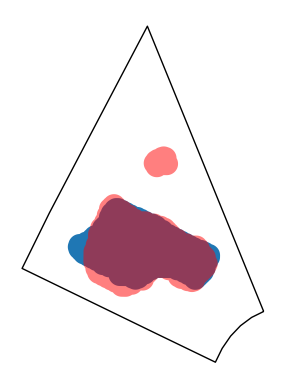

In [46]:
fig, ax = plt.subplots()
parcel_bounds.plot(ax=ax, facecolor='none')
inferred_buildings_2016_parcel.plot(ax=ax)
inferred_buildings_2020_parcel.plot(ax=ax, color='red', alpha=0.5)
ax.axis('off')
plt.show()

In [45]:
parcel_sbuild_2020

,APN,area,year,geometry,expansion_2016_flag,diff_2016_value
0,70617035,178.435864,2020,"POLYGON ((-121.76412 37.22964, -121.76412 37.2...",False,9.29678
1,70617035,15.941208,2020,"POLYGON ((-121.76402 37.22976, -121.76402 37.2...",True,15.941208
